In [2]:
# Define a simple resnet50 pretrained model:
from monai.networks.nets import resnet18, resnet50, resnet101
import matplotlib.pyplot as plt
from scripts.utils import load_metadata
from scripts.data import load_2D_data
from monai import transforms

from torch.utils.data import Dataset, DataLoader

from pytorch_lightning.loggers import WandbLogger 
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

import torch
from torch import nn
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_metric_learning import losses
import numpy as np

from monai import transforms

metadata = load_metadata()
load_transform = transforms.ScaleIntensity(minv=0.0, maxv=1.0, channel_wise=True)


/home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [4]:
class Contrastive(pl.LightningModule):
    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes
        self.encoder = resnet50(spatial_dims=2, num_classes=self.n_classes, n_input_channels=1)
        self.head = MLP(self.n_classes, 8)
        self.loss = losses.NTXentLoss(temperature=0.07)
        self.save_hyperparameters()

    def forward(self, x):
        return self.head(self.encoder(x))
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        x = self(x)
        loss = self.loss(x, y)
        self.log("train_loss", loss, prog_bar=True, on_epoch=True, on_step=False)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = self(x)
        loss = self.loss(x, y)
        self.log("val_loss", loss, prog_bar=True, on_epoch=True, on_step=False)
        return loss
    
    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return self.optimizer

In [5]:
metadata = load_metadata()
n_samples = 800
train_data = []
valid_data = []
valid_labels = []

for centre in range(1, 6):
    images, labels, _ = load_2D_data(centre=centre, metadata=metadata, transform=load_transform)
    train_data.append(images[:n_samples])
    valid_data.append(images[n_samples:n_samples+200])
    valid_labels.append(labels[n_samples:n_samples+200])

# test_data = []
# for centre in range(4, 6):
#     images, _, _ = load_2D_data(
#     centre=centre, metadata=metadata, transform=load_transform)
#     test_data.append(images[n_samples:n_samples+200])

Loading Images for centre:  1
Loading Labels for centre:  1


  0%|          | 0/89 [00:00<?, ?File/s]

100%|██████████| 89/89 [00:01<00:00, 57.45File/s]


Loading Images for centre:  2
Loading Labels for centre:  2


100%|██████████| 71/71 [00:01<00:00, 52.56File/s]


Loading Images for centre:  3
Loading Labels for centre:  3


100%|██████████| 50/50 [00:00<00:00, 66.82File/s]


Loading Images for centre:  4
Loading Labels for centre:  4


100%|██████████| 47/47 [00:00<00:00, 64.92File/s]


Loading Images for centre:  5
Loading Labels for centre:  5


100%|██████████| 48/48 [00:00<00:00, 58.54File/s]


In [6]:
class ContrastiveDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data[0])

    def __getitem__(self, index):
        centre = index % len(self.data)
        # randomly pick an image from that centre
        image = self.data[centre][np.random.randint(0, len(self.data[centre]))]

        return image, centre

In [7]:
train_dataset = ContrastiveDataset(train_data)
valid_dataset = ContrastiveDataset(valid_data)

In [8]:
pl.seed_everything(42)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

Global seed set to 42


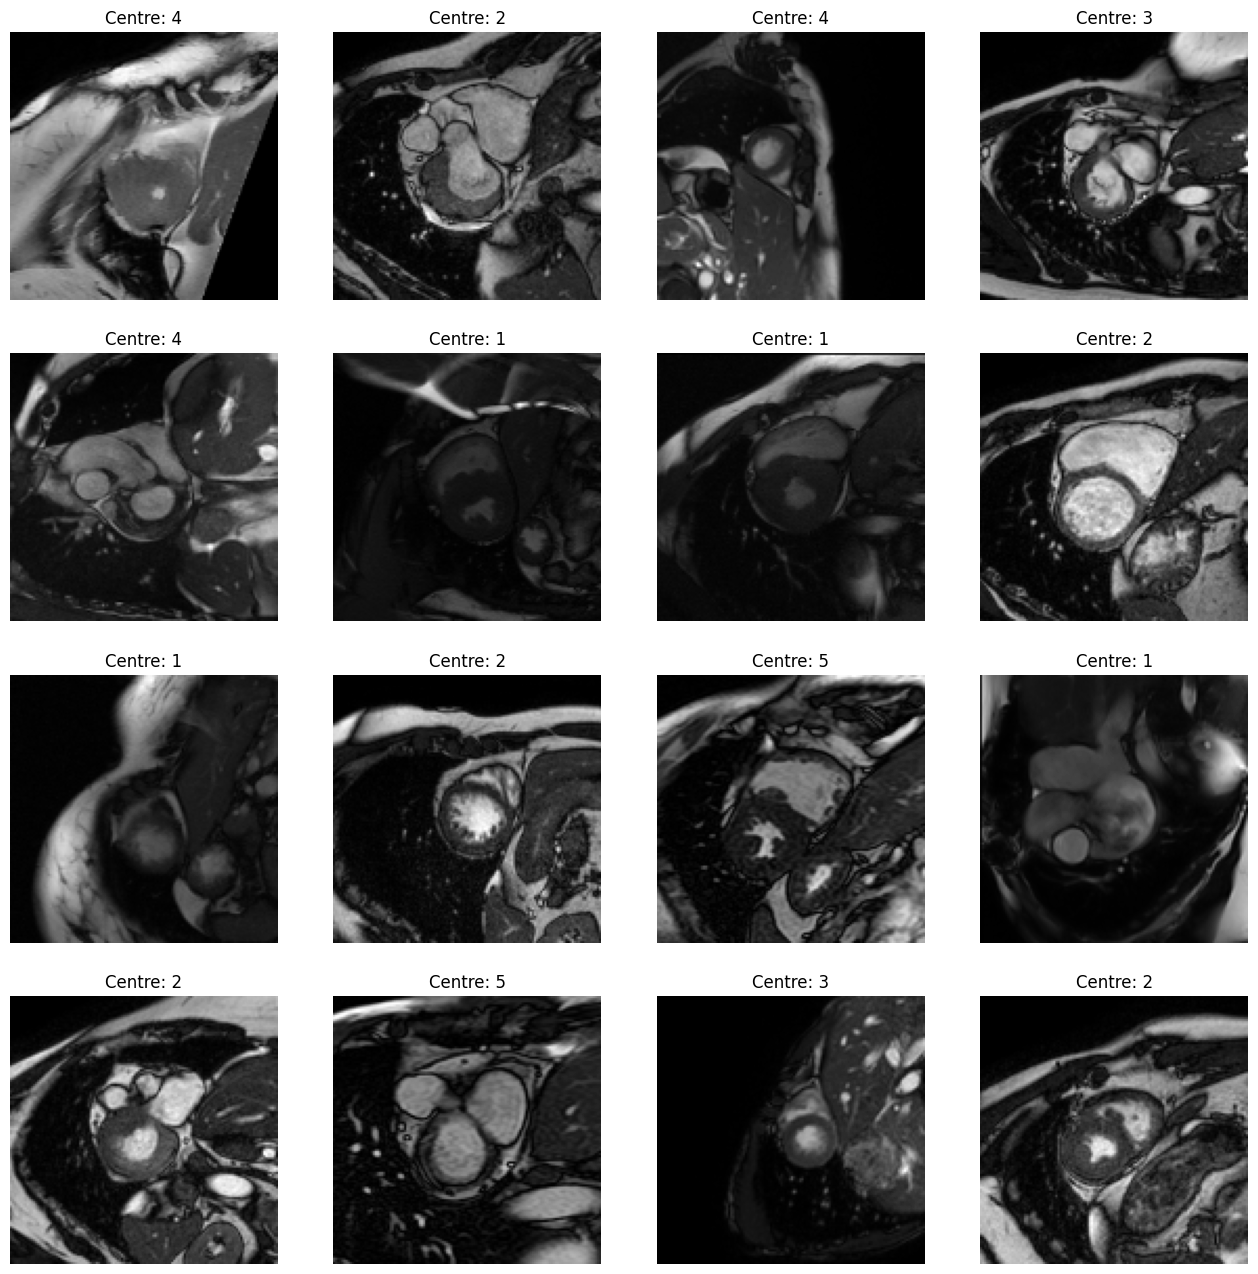

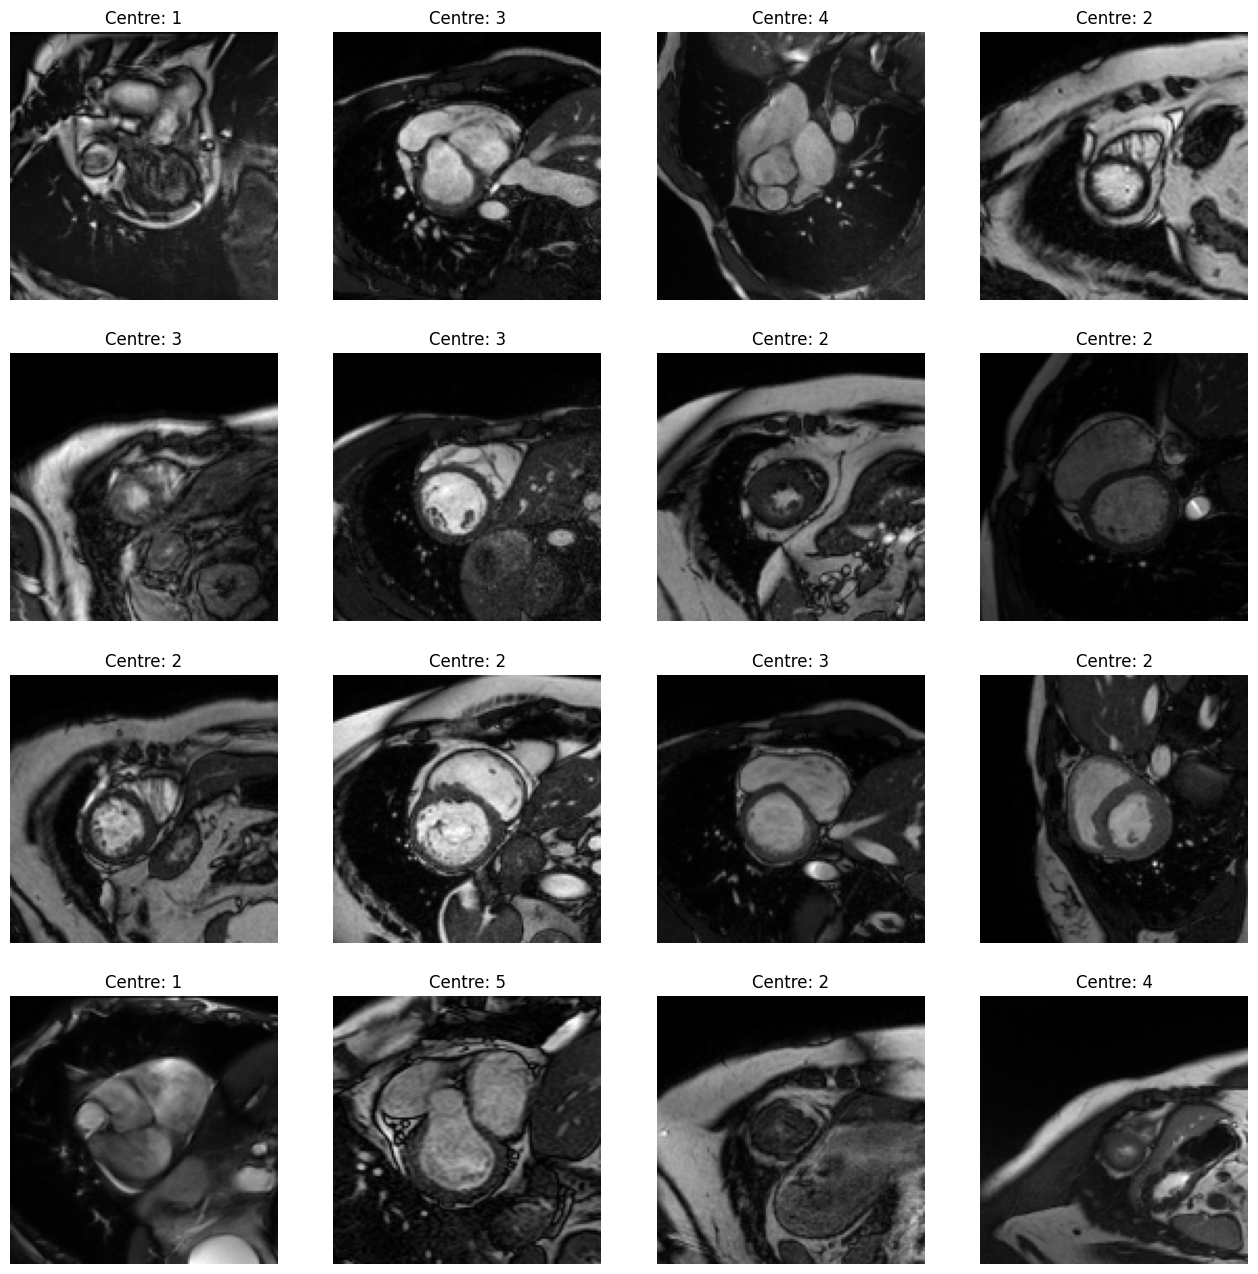

In [9]:
# Visuale a batch of data
for j, (images, labels) in enumerate(train_loader):
    plt.figure(figsize=(16, 16))
    for i in range(batch_size):
        plt.subplot(batch_size//4, 4, i + 1)
        image, centre = images[i], labels[i]
        plt.imshow(image.squeeze(), cmap="gray")
        plt.title(f"Centre: {centre+1}")
        plt.axis("off")

    if j>0:
        break

In [11]:
# # Initialize model
# n_classes = 32
# model = Contrastive(n_classes)

# pl.seed_everything(42)

# trainer = pl.Trainer(
#     max_epochs=50,
#     deterministic=True,
#     enable_model_summary=True,
#     callbacks=[EarlyStopping("val_loss", patience=5), ModelCheckpoint(monitor="val_loss")],
#     enable_progress_bar=True,
#     enable_checkpointing=True,
#     fast_dev_run=False,
# )

# #  Train model
# trainer.fit(model, train_loader, val_loader)


In [14]:
# print(trainer.checkpoint_callback.best_model_path)
# print(trainer.checkpoint_callback.best_model_score)
best_path = "/home/ids/mahdi-22/M-M/lightning_logs/version_44512/checkpoints/epoch=21-step=1100.ckpt"
encoder = Contrastive.load_from_checkpoint(best_path).encoder
encoder.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNetBottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [15]:
# Implement a clustering algorithm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from einops import pack

In [16]:
visualize = False
# pack data
images, ps = pack(valid_data, pattern='* c h w')
labels = []
for i in range(5): labels += [i]*200 

pred = encoder.to("cpu")(images)
pred = pred.detach().numpy()

# Create and fit k-NN classifier
k = 5  # Number of neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_classifier.fit(pred, labels)

y_pred = knn_classifier.predict(pred)
# Calculate accuracy
accuracy = accuracy_score(labels, y_pred)
print(f"Accuracy: {accuracy:.2f}")

if visualize:
    # Visualize the data points and clusters
    plt.scatter(pred[:, 0], pred[:, 1], c=labels, marker='o', label='True Labels')
    plt.scatter(pred[:, 0], pred[:, 1], c=y_pred, marker='x', label='Predicted Labels')
    plt.legend()
    plt.title("True vs Predicted Labels")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

Accuracy: 0.90


In [17]:
best_params = {'bias_coeff': 0.3, 'contrast_gamma': 1.5, 'zoom_factor': 1.1, 'zoom_padding': 'reflect', 'smooth_sigma': 0.9}

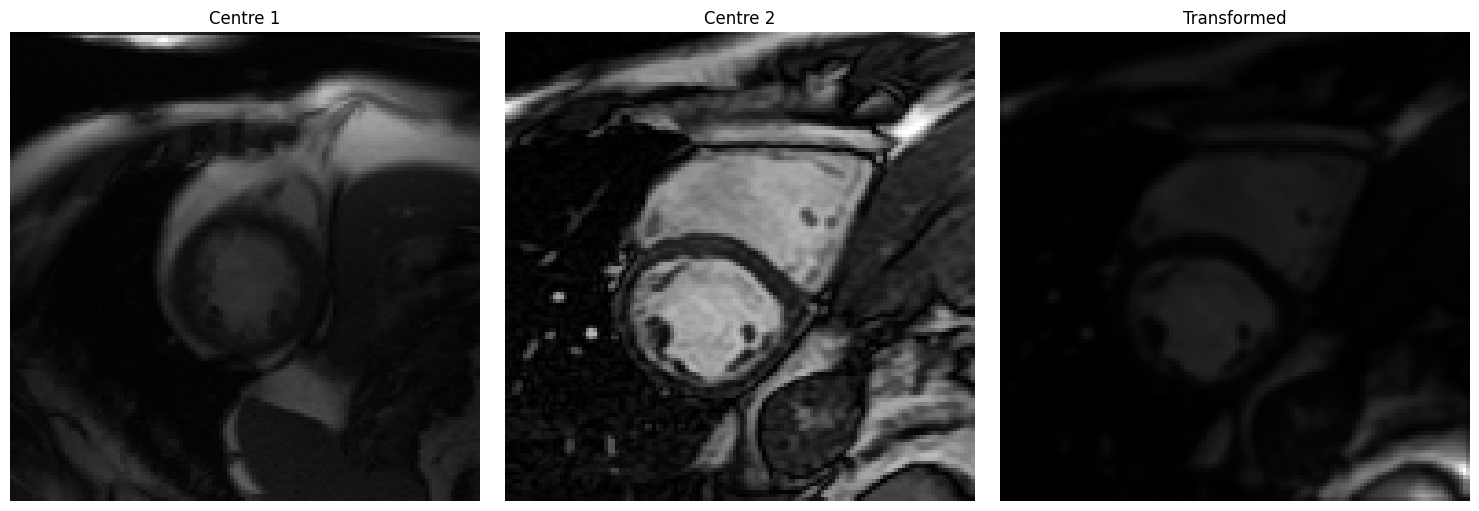

Distance between transformed image and original image:  26.114538
Distance between transformed and cluster_centre:  7.897757
Distance between original and cluster_centre:  31.531372


In [28]:
# get the average of class 0
cluster_centre = pred[:200].mean(0).reshape(1, -1)

image_centre1 = valid_data[0][20]

image_centre2 = valid_data[4][60]
seg = valid_labels[4][61]


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Remove axes from both subplots
for ax in axes:
    ax.axis('off')

# Display the first image on the first subplot
axes[0].imshow(image_centre1[0], cmap='gray')
axes[0].set_title('Centre 1')

# Display the second image on the second subplot
axes[1].imshow(image_centre2[0], cmap='gray')
axes[1].set_title('Centre 2')


transform = transforms.Compose([
    transforms.RandBiasFieldd(keys=("img",), prob=1, coeff_range=(best_params['bias_coeff'], best_params['bias_coeff'])),
    transforms.AdjustContrastd(keys=("img",), gamma=best_params['contrast_gamma']),
    # transforms.Zoomd(keys=("img","seg"), zoom=best_params["zoom_factor"], padding_mode=[best_params["zoom_padding"], "nearest"]),
    transforms.GaussianSmoothd(keys=("img",), sigma=best_params['smooth_sigma']),
])

data = {"img": image_centre2, "seg": seg}

transformed_data = transform(data)
transformed = transformed_data["img"]
transformed_seg = transformed_data["seg"]

# Display the second image on the second subplot
axes[2].imshow(transformed[0], cmap='gray')
axes[2].set_title('Transformed')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

pred_transformed = encoder(transformed.unsqueeze(0)).detach().numpy()
pred_original = encoder(image_centre2.unsqueeze(0)).detach().numpy()


print("Distance between transformed image and original image: ", np.linalg.norm(pred_transformed - pred_original))
print("Distance between transformed and cluster_centre: ", np.linalg.norm(pred_transformed - cluster_centre))
print("Distance between original and cluster_centre: ", np.linalg.norm(pred_original - cluster_centre))

In [20]:
# get the average of class 0
cluster_centre = pred[:200].mean(0).reshape(1, -1)

image_centre1 = valid_data[0][20]

image_centre2 = valid_data[4][60]
seg = valid_labels[4][61]


points = []
gammas = [0., 0.3, 0.5, 0.7, 0.8, 1., 1.2 ,1.5]
examples = [image_centre2]
for smooth_sigma in gammas:
    transform = transforms.Compose([
        # transforms.RandBiasFieldd(keys=("img",), prob=1, coeff_range=(best_params['bias_coeff'], best_params['bias_coeff'])),
        # transforms.AdjustContrastd(keys=("img",), gamma=contrast_gamma),
        # transforms.Zoomd(keys=("img","seg"), zoom=best_params["zoom_factor"], padding_mode=[best_params["zoom_padding"], "nearest"]),
        transforms.GaussianSmoothd(keys=("img",), sigma=smooth_sigma),


    ])

    data = {"img": image_centre2, "seg": seg}

    transformed_data = transform(data)
    transformed = transformed_data["img"]
    transformed_seg = transformed_data["seg"]


    examples.append(transformed)
    pred_transformed = encoder(transformed.unsqueeze(0)).detach().numpy()
    points.append(pred_transformed.squeeze())

    pred_original = encoder(image_centre2.unsqueeze(0)).detach().numpy()


    print(f"For Gamma = {smooth_sigma}") 
    print("     Distance between transformed image and original image: ", np.linalg.norm(pred_transformed - pred_original))
    print("     Distance between transformed and cluster_centre: ", np.linalg.norm(pred_transformed - cluster_centre))
    print("     Distance between original and cluster_centre: ", np.linalg.norm(pred_original - cluster_centre))

points = np.array(points)


For Gamma = 0.0
     Distance between transformed image and original image:  0.0
     Distance between transformed and cluster_centre:  31.531372
     Distance between original and cluster_centre:  31.531372
For Gamma = 0.3
     Distance between transformed image and original image:  5.3665776
     Distance between transformed and cluster_centre:  30.18614
     Distance between original and cluster_centre:  31.531372
For Gamma = 0.5
     Distance between transformed image and original image:  17.790451
     Distance between transformed and cluster_centre:  21.583597
     Distance between original and cluster_centre:  31.531372
For Gamma = 0.7
     Distance between transformed image and original image:  33.39371
     Distance between transformed and cluster_centre:  17.23243
     Distance between original and cluster_centre:  31.531372
For Gamma = 0.8
     Distance between transformed image and original image:  39.07346
     Distance between transformed and cluster_centre:  18.992954
  

In [18]:
# # Define parameter ranges for the transformations
# param_grid = {
#     'bias_coeff': [0.2, 0.3, 0.4],
#     'contrast_gamma': [0.5, 0.7, 1.0, 1.3, 1.5],
#     'zoom_factor': [0.7, 0.9, 1.0, 1.1],
#     'zoom_padding': ["reflect", "circular", "constant"],
#     'smooth_sigma': [0.7, 0.9, 1.0, 1.2],
# }

# min_distance = float('inf')
# best_params = {}

# for bias_coeff in param_grid['bias_coeff']:
#     for contrast_gamma in param_grid['contrast_gamma']:
#         for zoom_factor in param_grid['zoom_factor']:
#             for zoom_padding in param_grid['zoom_padding']:
#                 for smooth_sigma in param_grid['smooth_sigma']:
#                     transform = transforms.Compose([
#                         transforms.RandBiasField(prob=1, coeff_range=[bias_coeff, bias_coeff]),
#                         transforms.AdjustContrast(gamma=contrast_gamma),
#                         transforms.Zoom(zoom_factor, padding_mode=zoom_padding),
#                         transforms.GaussianSmooth(sigma=smooth_sigma),
#                     ])
#                     transformed = transform(image_centre2)

#                     pred_transformed = encoder(transformed.unsqueeze(0)).detach().numpy()

#                     distance = np.linalg.norm(pred_transformed - cluster_centre)
#                     if distance < min_distance:
#                         min_distance = distance
#                         best_params = {
#                             'bias_coeff': bias_coeff,
#                             'contrast_gamma': contrast_gamma,
#                             'zoom_factor': zoom_factor,
#                             'zoom_padding': zoom_padding,

#                             'smooth_sigma': smooth_sigma,
#                         }

# print("Best Parameters:", best_params)
# print("Minimum Distance:", min_distance)

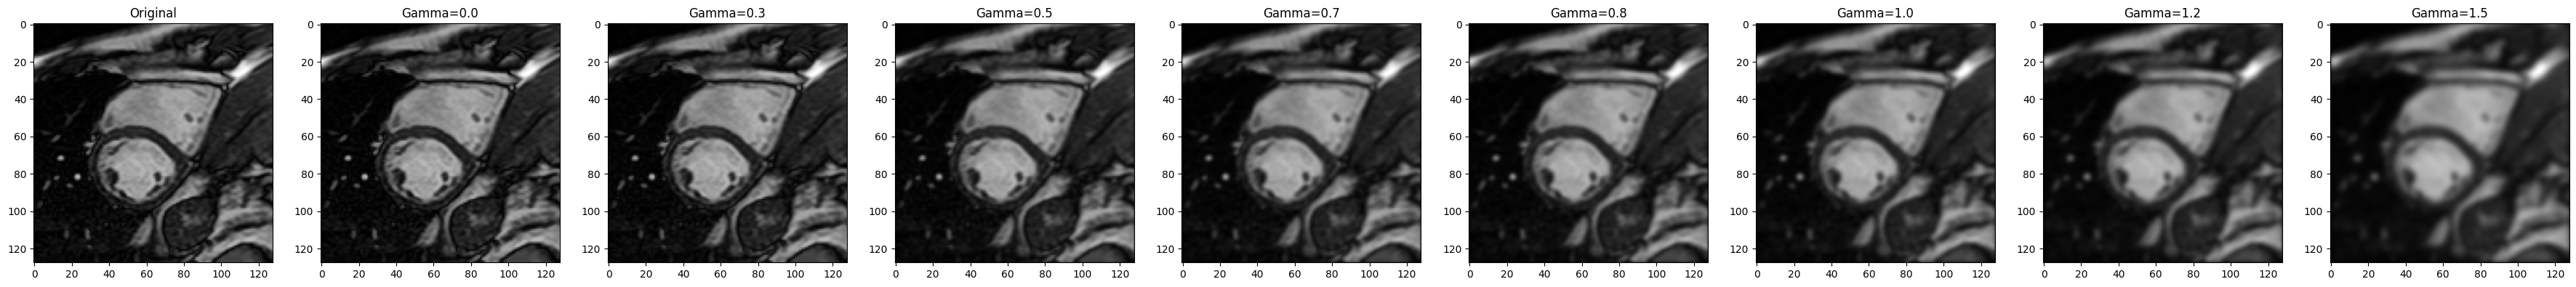

In [21]:
# show all examples in a subplots
titles = ['Original'] + [f'Gamma={gamma}' for gamma in gammas]
fig, axs = plt.subplots(1, len(examples), figsize=(5*len(examples), 5))

for i, example in enumerate(examples):
    axs[i].imshow(example[0], cmap='gray')
    axs[i].set_title(titles[i])

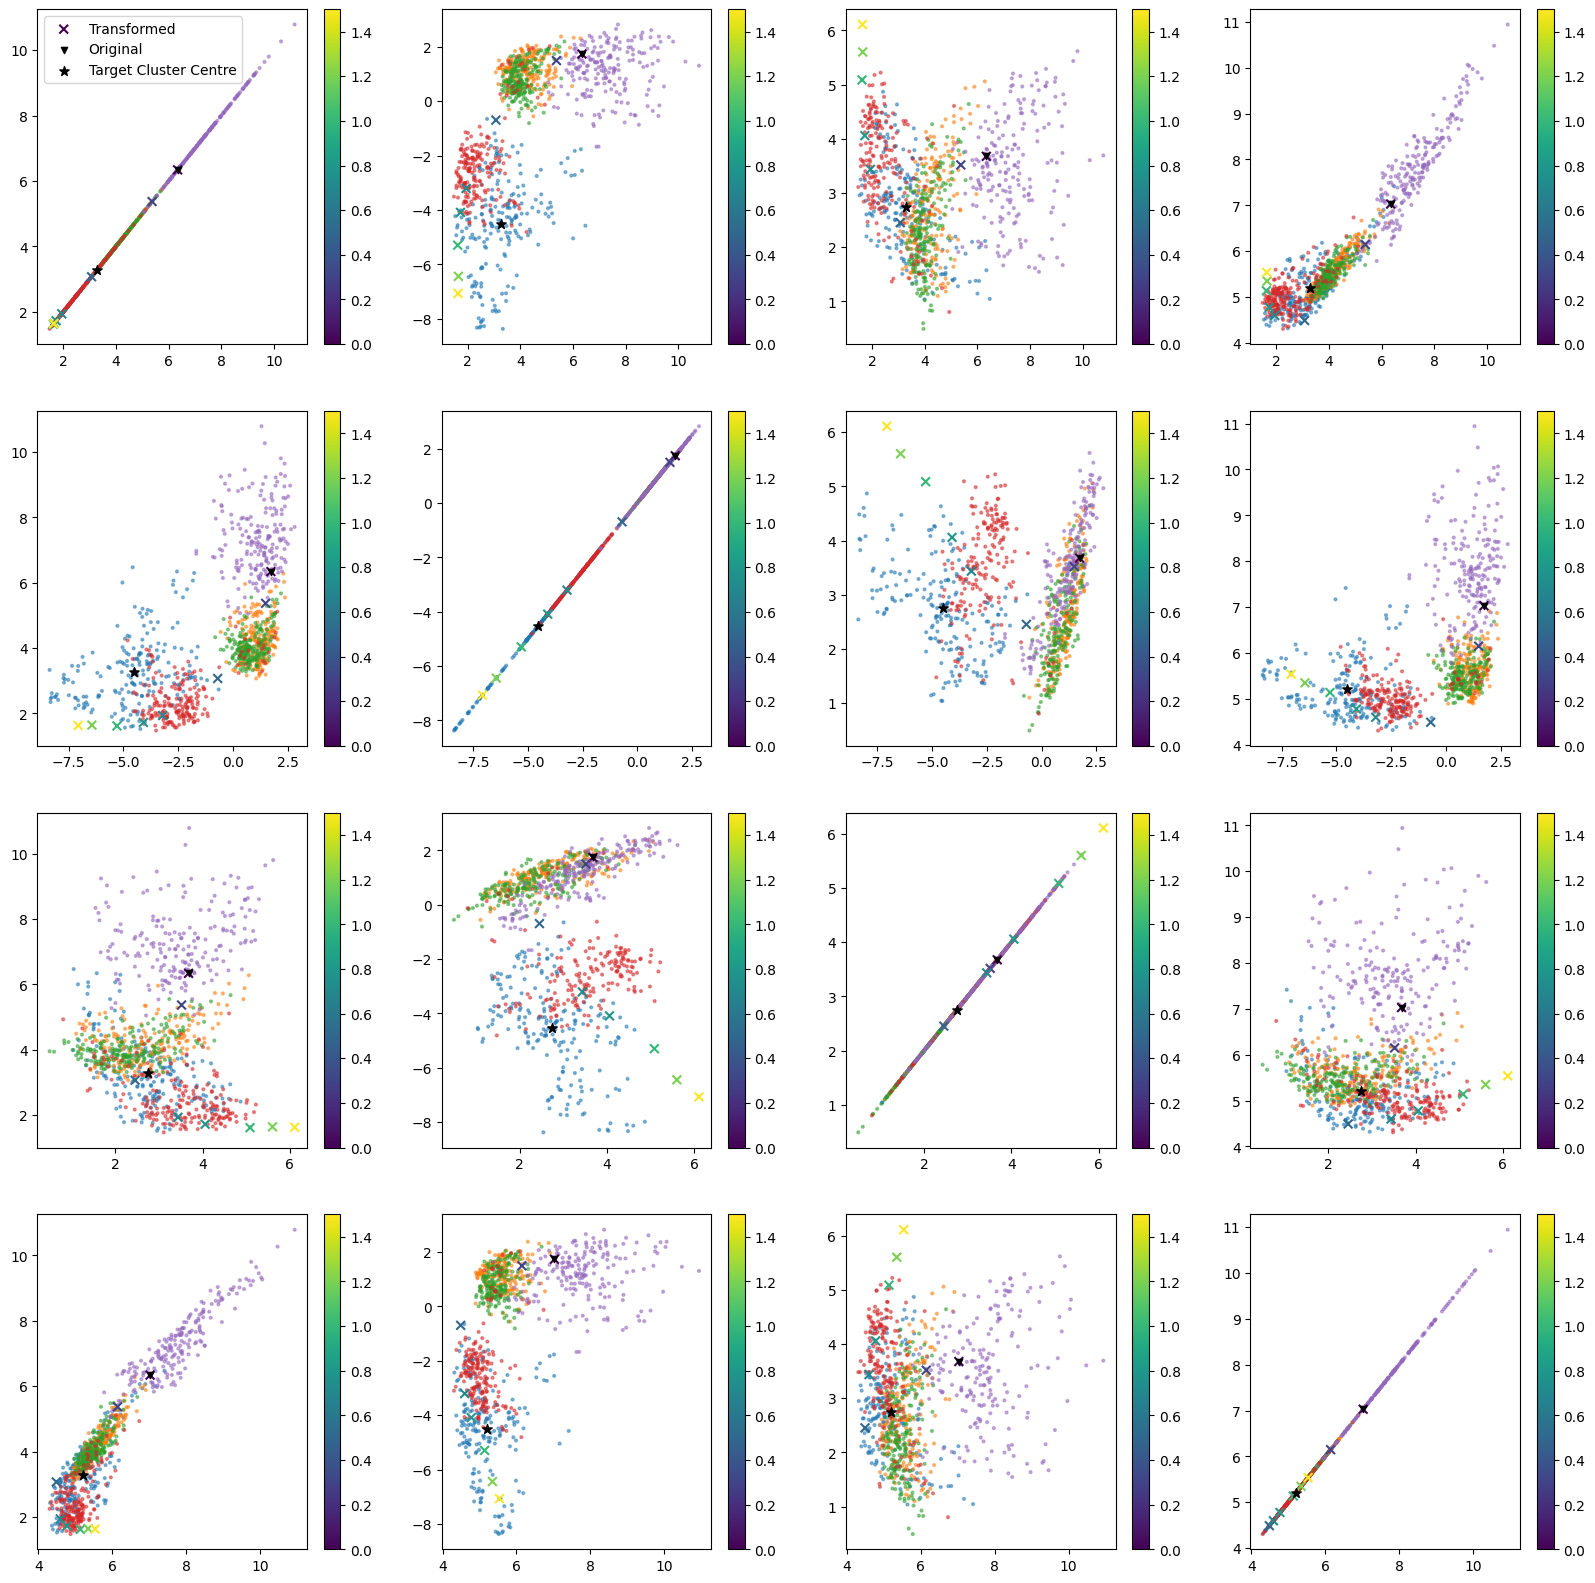

In [23]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
colormap = [colors[i] for i in labels]


plt.figure(figsize=(20,20))
n_plots = 4

for j in range(n_plots):
    for k in range(n_plots):
        plt.subplot(n_plots, n_plots, j*n_plots+k+1)
        plt.scatter(pred[:, j], pred[:, k], c=colormap, alpha=0.5, s=4)

        plt.scatter(points[:, j], points[:, k], marker="x", alpha=1, c=gammas ,s=40, label="Transformed") 
        plt.colorbar()
        plt.scatter(pred_original[0, j], pred_original[0, k], c='k', alpha=1, marker="v", s=20, label="Original") 
        plt.scatter(cluster_centre[0, j], cluster_centre[0, k], c='k', alpha=1, marker="*", s=50, label="Target Cluster Centre")
        if j == 0 and k == 0:
            plt.legend(loc="upper left")
        


plt.show()

In [24]:
from scripts.train import LitUnet 
seg_model = LitUnet.load_from_checkpoint("models/benchmark/benchmark.ckpt")

from scripts.metrics import compute_scores

In [29]:
scores1 = []
scores2 = []
cluster_centre = pred[:200].mean(0).reshape(1, -1)



y_pred = seg_model._get_predictions(transformed.unsqueeze(0))
y_pred_original = seg_model._get_predictions(examples[0].unsqueeze(0))

scores1.append(compute_scores(seg, y_pred_original))
scores2.append(compute_scores(seg, y_pred))



scores1 = np.array(scores1)
scores2 = np.array(scores2)

In [26]:
scores = []
y_pred_all = []
for i, example in enumerate(examples):
    y_pred = seg_model._get_predictions(example.unsqueeze(0))
    y_pred_all.append(y_pred)
    scores.append(compute_scores(seg, y_pred))

scores = np.array(scores)
scores.shape

(9, 8)

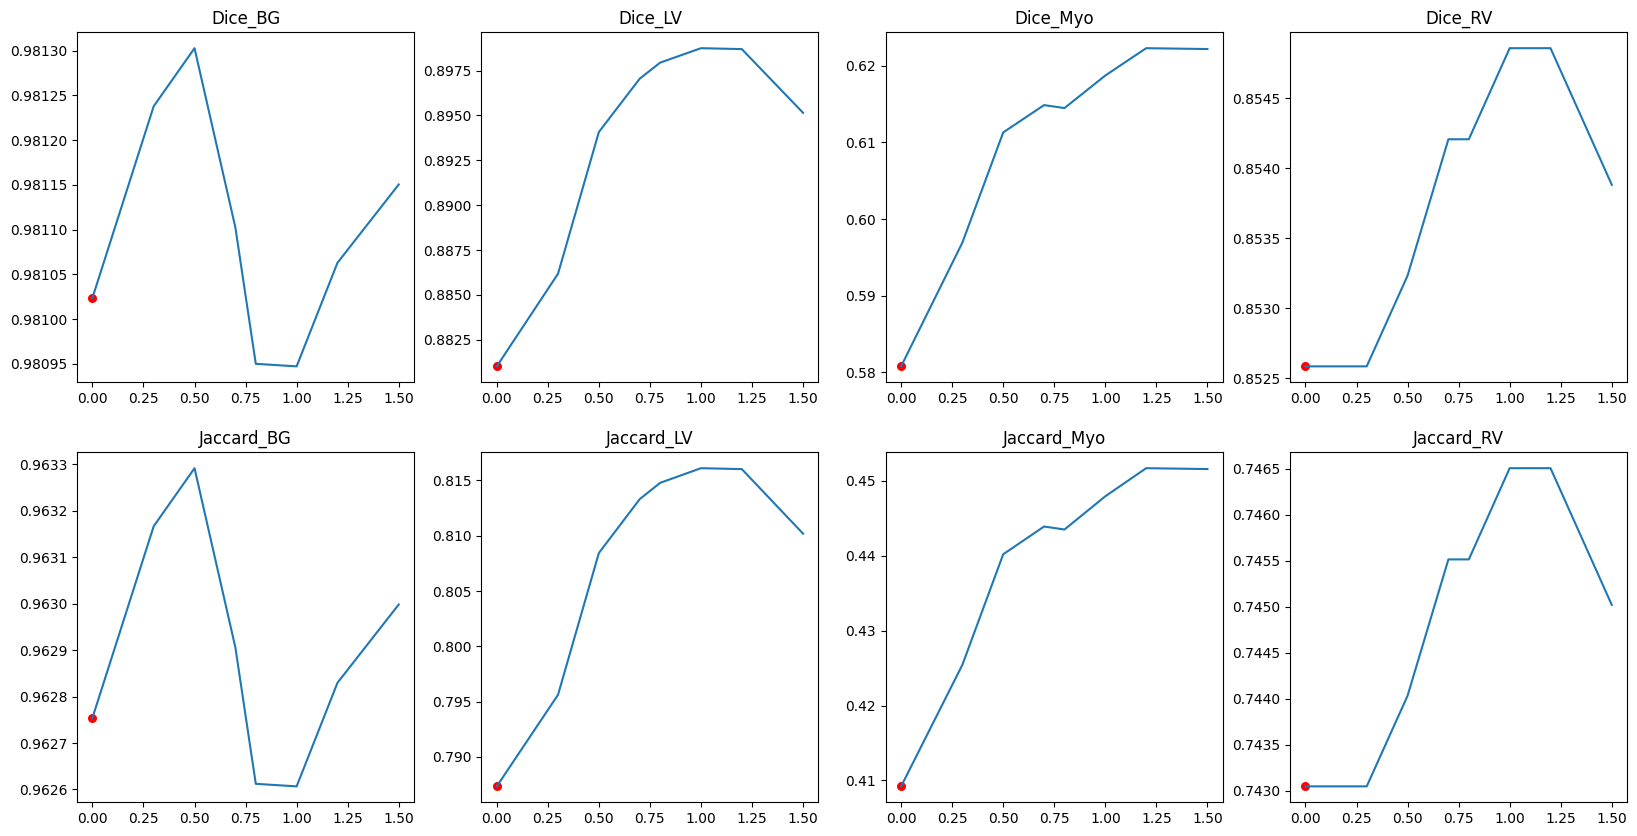

In [27]:
metric_names = ['Dice_BG', 'Dice_LV', 'Dice_Myo', 'Dice_RV', 'Jaccard_BG', 'Jaccard_LV', 'Jaccard_Myo', 'Jaccard_RV']
n = scores.shape[1]
fig, axs = plt.subplots(2, n//2, figsize=((n//2)*5, 2*5))

axs = axs.reshape(-1) 

for i in range(n):
    axs[i].plot(gammas , scores[1:, i])
    axs[i].scatter([0.] ,scores[0, i], marker="o", s=30, c="r")
    axs[i].set_title(metric_names[i])

In [36]:
print("Average of original images", scores1.mean(0))
print("Average of transformed images", scores2.mean(0))

Average of original images [0.98102353 0.88101726 0.58075601 0.85258359 0.96275387 0.78733766
 0.40920097 0.74304636]
Average of transformed images [0.98115042 0.89514299 0.62218515 0.85388128 0.96299831 0.81018899
 0.45157385 0.74501992]


Text(0.5, 1.0, 'Predicted segmentation of transformed image')

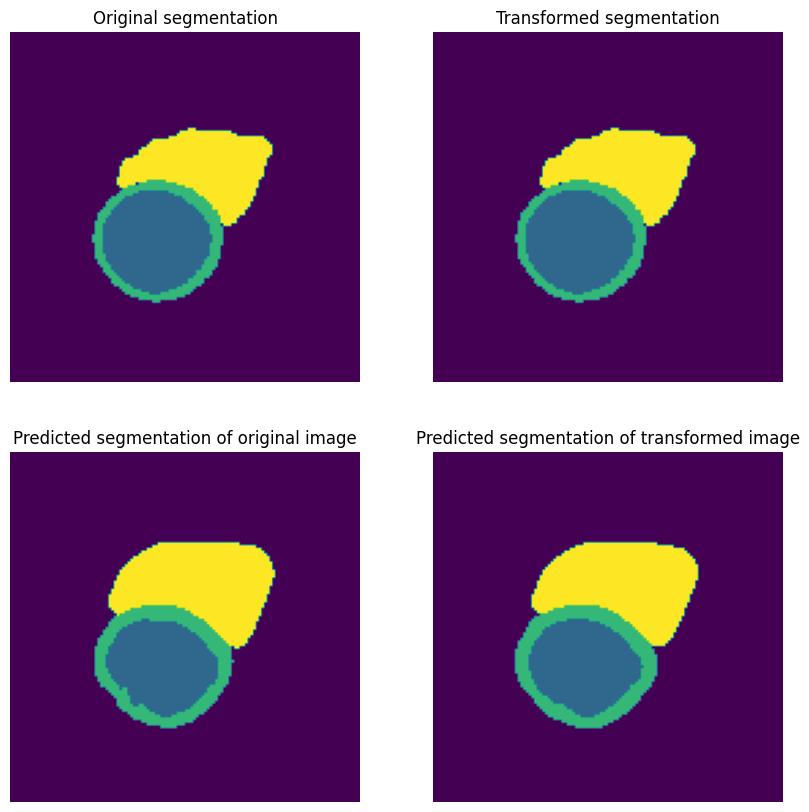

In [37]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(seg[0])
plt.axis('off')
plt.title("Original segmentation")
plt.subplot(2, 2, 2)
plt.imshow(transformed_seg[0])
plt.axis('off')
plt.title("Transformed segmentation")
plt.subplot(2, 2, 3)
plt.imshow(y_pred_original[0])
plt.axis('off')
plt.title("Predicted segmentation of original image")
plt.subplot(2, 2, 4)
plt.imshow(y_pred_all[-2][0])
plt.axis('off')
plt.title("Predicted segmentation of transformed image")


Text(0.5, 0.98, 'Predicted segmentations of transformed images with different blur parameters')

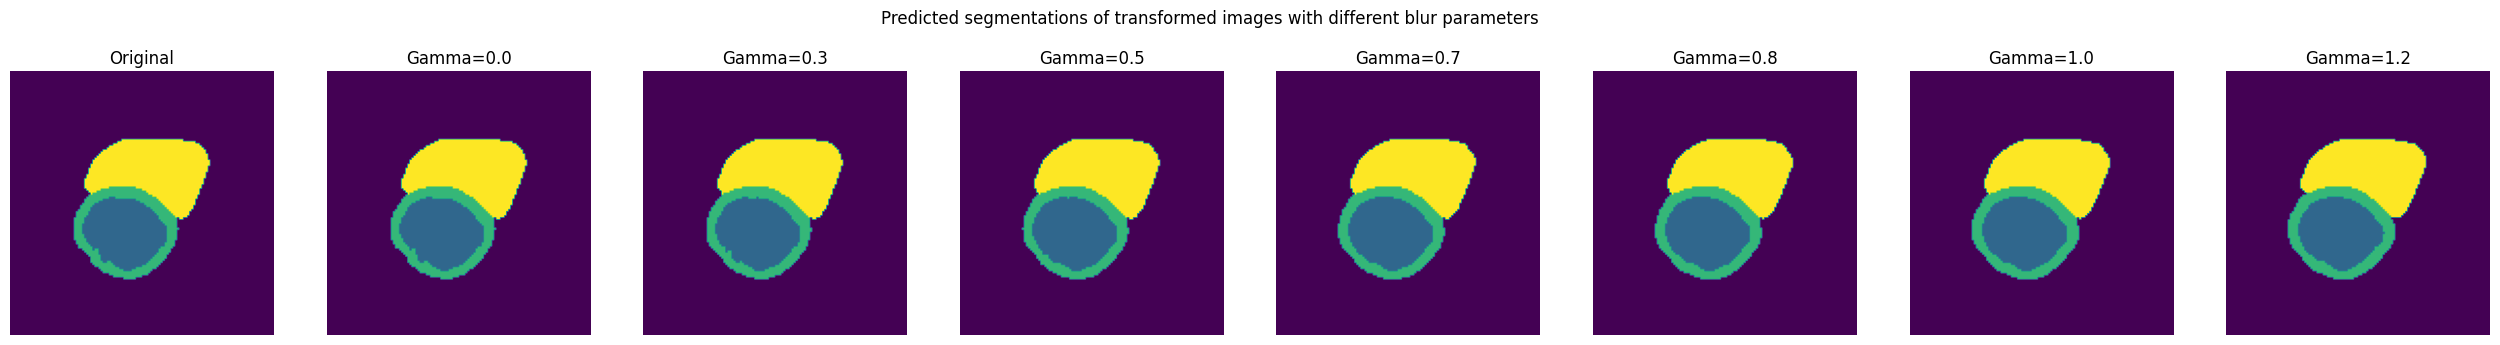

In [48]:
fig, axs = plt.subplots(1, n, figsize=(n*4, 4))

axs = axs.reshape(-1) 

for ax in axs:
    ax.axis('off')


for i in range(n):
    axs[i].imshow(y_pred_all[i][0])
    axs[i].set_title(titles[i])


plt.suptitle("Predicted segmentations of transformed images with different blur parameters")

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import SGD

import matplotlib.pyplot as plt


def transformation_to_optimize(image, contrast_gamma):
    transform = transforms.Compose([
        transforms.RandBiasField(prob=1, coeff_range=[contrast_gamma, contrast_gamma]),
        transforms.AdjustContrast(gamma=contrast_gamma),
        transforms.GaussianSmooth(sigma=smooth_sigma),
    ])
    transformed = transform(image)

    pred_transformed = encoder(transformed.unsqueeze(0))
    return pred_transformed


if __name__ == "__main__":
    batch_size = 50

    # Make the variable an optimizable parameter
    contrast_gamma = nn.Parameter(torch.tensor(1.1))

    # Optimizer takes an iterable, so put the variable in a list
    optimizer = SGD([contrast_gamma], lr=10)

    # loss criterion
    crit = nn.MSELoss()

    logs = {"contrast_gamma": [], "loss": []}
    for step in range(20):
        optimizer.zero_grad()

        image = valid_data[4][60]
        # Your function for which you want to optimize the parameter
        y_hat = transformation_to_optimize(image, contrast_gamma)
        # Ground truth value
        y = torch.tensor(cluster_centre)

        # Classic loss stuff
        loss = crit(y, y_hat)
        loss.backward()

        optimizer.step()

        # visualization purposes
        logs["contrast_gamma"].append(contrast_gamma.detach().item())
        logs["loss"].append(loss.item())

    # Visualization
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].plot(logs["loss"])
    ax[0].set_title("Loss")
    ax[1].plot(logs["contrast_gamma"])
    ax[1].set_title("Evolution of contrast_gamma")
    plt.show()

ValueError: gamma must be a float or int number, got <class 'torch.nn.parameter.Parameter'> Parameter containing:
tensor(1.1000, requires_grad=True).